## Pixel to Gaussian: Ultra-Fast Continuous Super-Resolution with 2D Gaussian Modeling  

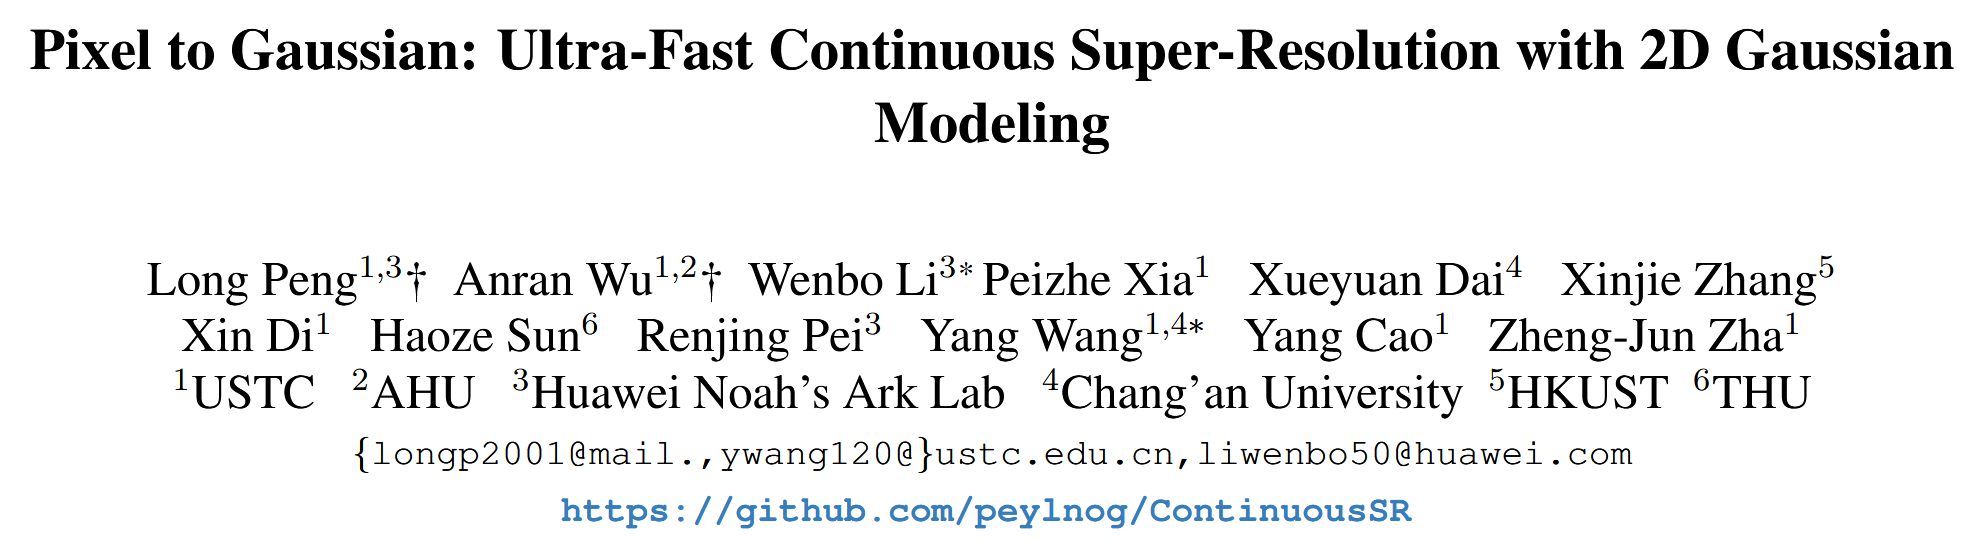

Github Repo:https://github.com/Xinjie-Q/GaussianImage, 
Corresponding code: ../../../../code/GS/ContinuousSR-main/demo.py

## 1. Highlights
TODO
## 2. Background

Although GaussianImage(https://xingtongge.github.io/GaussianImage-page/) is an efficient image representation and compression method using 2D Gaussian Splatting with up to 2000 FPS rendering speed, it cannot perform arbitrary-scale super-resolution because it lacks an end-to-end inference mechanism and requires overfitting each image individually.

Super-resolution (SR) aims to recover a high-resolution (HR) image from its low-resolution (LR) counterpart. Traditional SR methods focus on fixed integer scales like ×2, ×3, or ×4, which limits flexibility in real applications.  

To solve this, **Arbitrary-Scale Super-Resolution (ASSR)** was proposed. A landmark method, **LIIF** [Chen et al., 2021], introduces *implicit neural representation (INR)* to map coordinates to RGB values via an MLP. Given any continuous coordinate $(x, y)$, the network outputs the corresponding color, enabling continuous upscaling.

However, such INR-based methods suffer from:

- Inefficiency: each pixel requires repeated querying and decoding.
- Limited fidelity: coordinate-based MLPs struggle to capture high-frequency textures.
- Complex pipeline: involves multiple upsampling-decoding stages.

In essence, while INR methods can do continuous SR, they do so **slowly** and **with limited detail reconstruction**.

## 2. The Core Idea
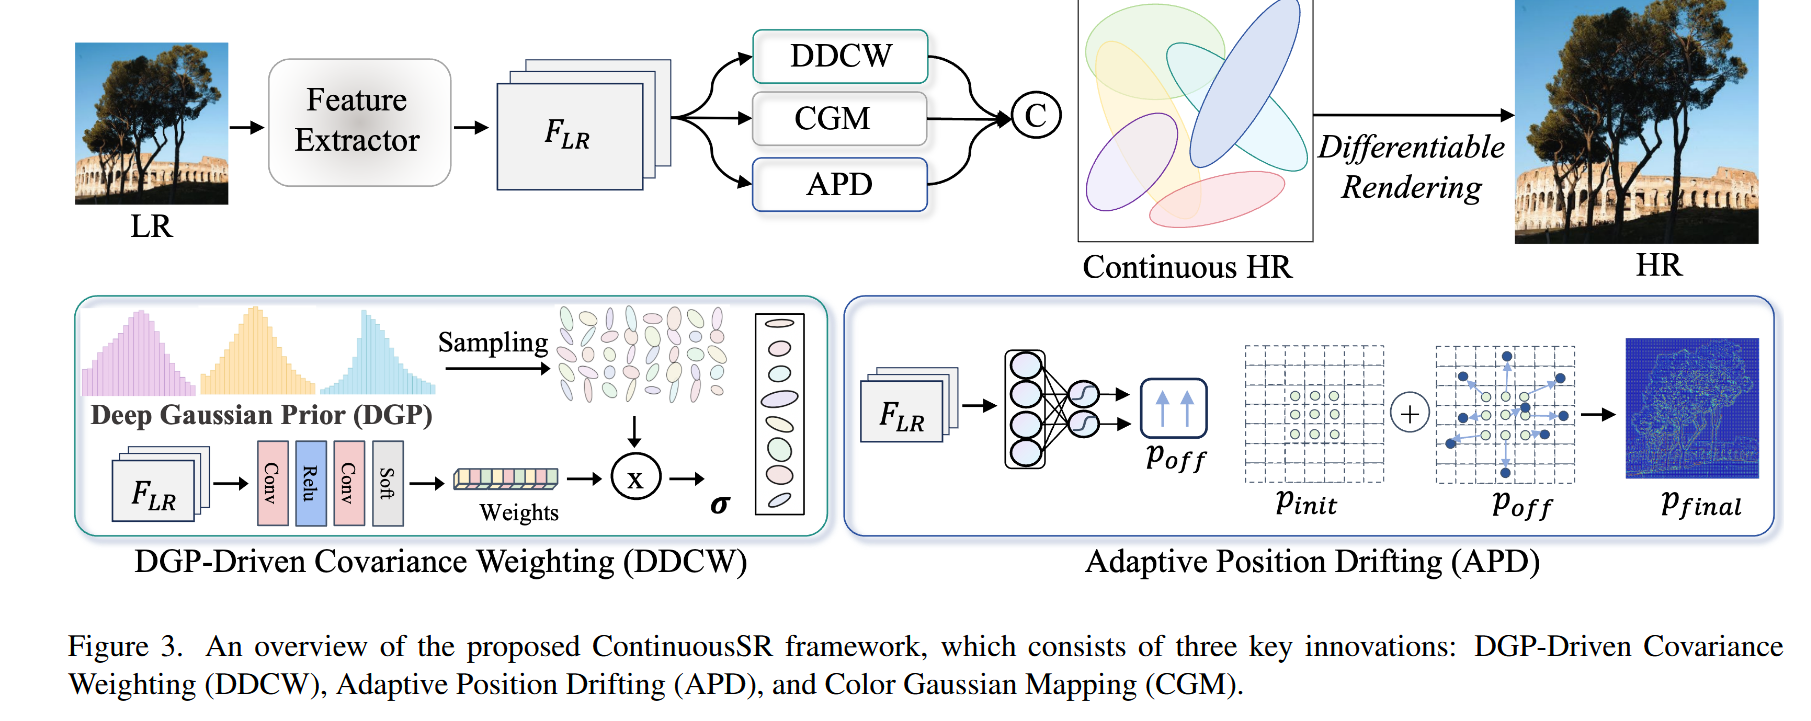
This paper proposes a fundamentally new idea:  
Instead of **learning a function to query pixels**, learn to **explicitly construct a continuous image field**, represented by a set of 2D **Gaussian kernels**.

Each kernel is parameterized by its spatial position $\mu$, covariance matrix $\Sigma$, and RGB color $c_{rgb}$. The reconstructed image is the sum of $N$ such Gaussians:

$$
f_c(x, y) = \sum_{i=1}^N G_i(x, y)
$$

Each Gaussian kernel $G_i$ is defined as:

$$
G_i(x, y, c_{rgb}, \Sigma) = c_{rgb} \cdot \frac{1}{2\pi |\Sigma|} \exp \left( -\frac{1}{2} d^T \Sigma^{-1} d \right)
$$

where $d = \begin{bmatrix} x - \mu_x \\ y - \mu_y \end{bmatrix}$.

The covariance matrix is:

$$
\Sigma = \begin{bmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y & \sigma_y^2
\end{bmatrix}
$$

### 2.1 Why not directly predict Gaussians from LR?

Directly predicting Gaussian parameters ($\mu$, $\Sigma$) from a low-resolution image is highly challenging due to the nature of the Gaussian space:

- The space is **high-dimensional and sensitive**.
- Even small errors in $\mu$ (position) or $\Sigma$ (covariance) can cause significant visual distortions.
- Direct optimization easily gets stuck in poor local minima.

To overcome this, the authors propose three key components:



#### 2.1.1 **Deep Gaussian Prior (DGP)**

The authors analyze 40,000 natural images and discover that the covariance parameters of Gaussian kernels follow a compact and roughly Gaussian-distributed range:

- $\sigma_x^2 \in [0, 2.4]$, $\sigma_y^2 \in [0, 2.2]$, $\rho \in [-0.9, 1.5]$

This prior, called **Deep Gaussian Prior (DGP)**, serves as a statistical guideline for efficient parameter estimation.

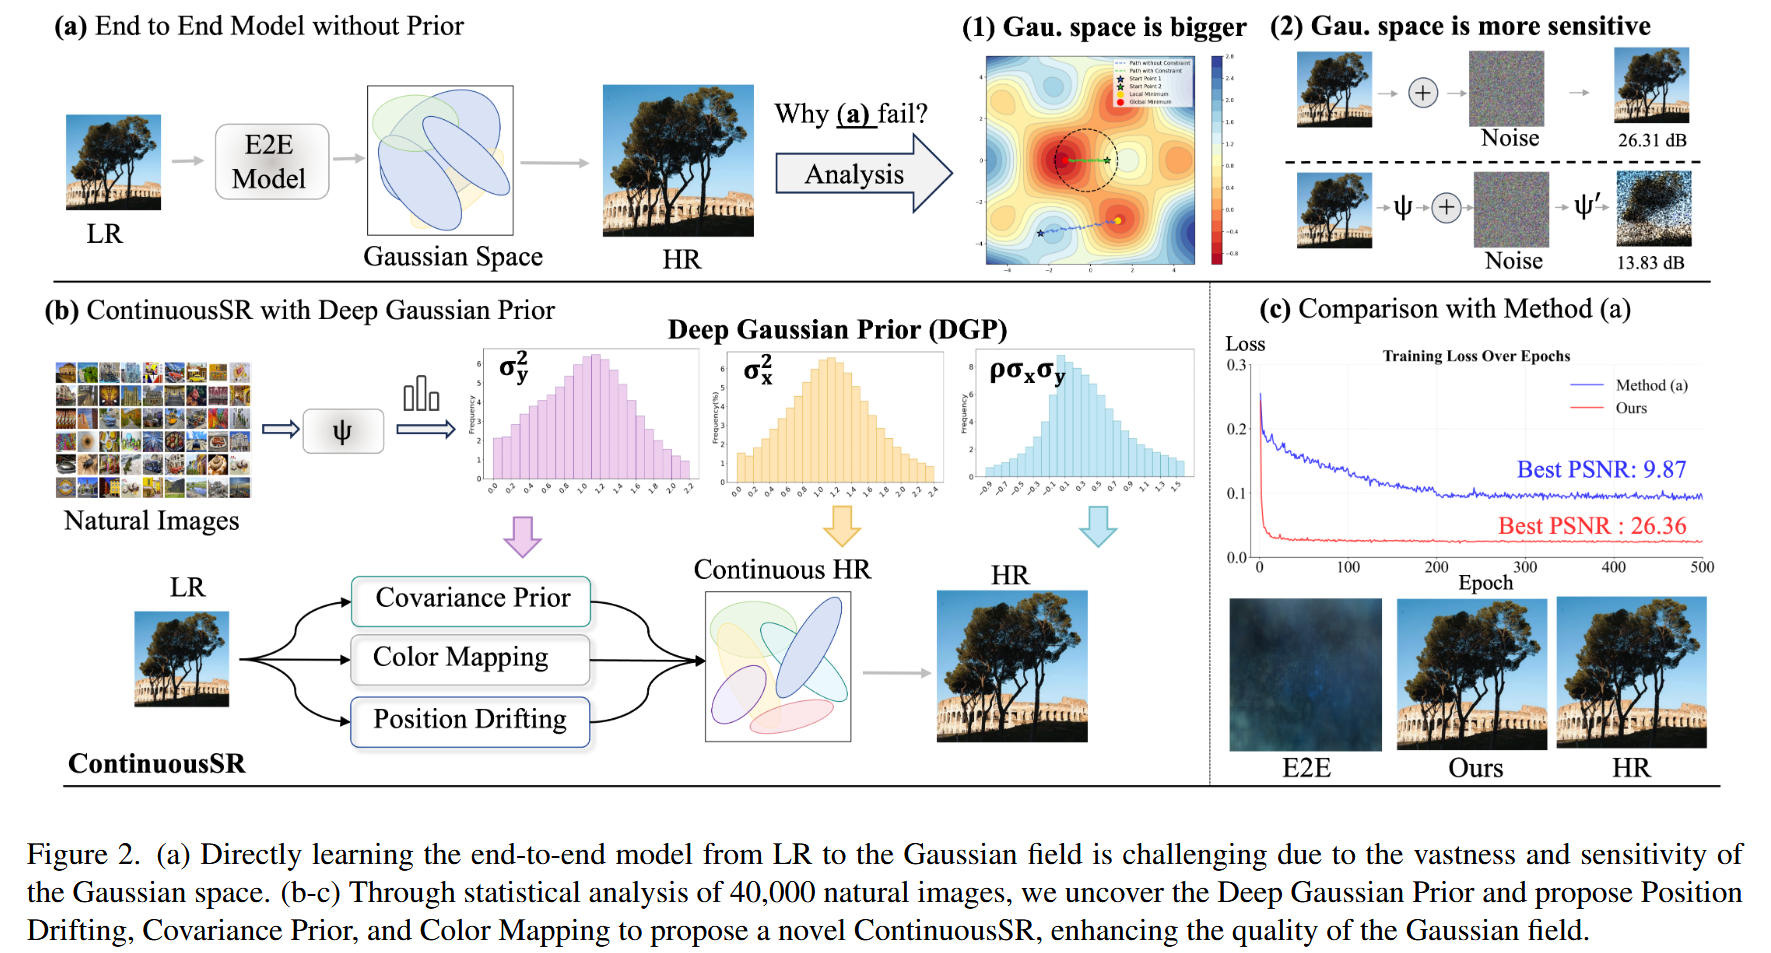

#### 2.1.2 **DGP-Driven Covariance Weighting (DDCW)**

Rather than directly predicting the full covariance matrix $\Sigma$, the model:

- Samples $N$ candidate Gaussian covariances from the DGP distribution;
- Learns a set of weights $w_i$ to form the final kernel as a weighted combination:

$$
G_{\text{target}} = \sum_{i=1}^N w_i \cdot G_i
$$

This drastically reduces the optimization complexity by converting regression into a soft selection problem.



#### 2.1.3 **Adaptive Position Drifting (APD)**

To avoid rigid Gaussian placements at LR grid centers, the model learns **dynamic position offsets** from LR image features:

$$
P_{\text{final}} = P_{\text{init}} + \tanh(\text{MLP}(F_{LR}))
$$

This enables the model to adaptively shift Gaussians toward textured or edge-rich regions, improving structural accuracy and expressiveness.



Together, DGP, DDCW, and APD allow robust, efficient modeling of Gaussian fields from LR images while avoiding the instability of naive direct prediction.

## 3. Contributions

- Propose **ContinuousSR**, the first to reconstruct 2D continuous signals explicitly from LR images using 2D Gaussian splatting.
- Discover **Deep Gaussian Prior (DGP)** and propose **DGP-Driven Covariance Weighting (DDCW)** to simplify optimization.
- Introduce **Adaptive Position Drifting (APD)** to dynamically place kernels based on image content.
- Achieve **19.5× speedup** and **+0.9 dB PSNR gain** over previous SOTA (e.g., CiaoSR, LIIF) on multiple benchmarks.



## 4. References

[1] Chen et al. "Learning Continuous Image Representation with Local Implicit Image Function." CVPR, 2021.  
[2] Peng et al. "Pixel to Gaussian: Ultra-Fast Continuous Super-Resolution with 2D Gaussian Modeling." CVPR, 2025.  
[3] Cao et al. "CiaoSR: Continuous Implicit Attention-in-Attention Network for ASSR." CVPR, 2023.  
[4] Zhang et al. "GaussianImage: High-Fidelity 2D Gaussian Splatting for SR." ECCV, 2024.  


# Demo

In [ ]:
import argparse

import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/GS/ContinuousSR-main"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

import math
from functools import partial

import yaml
import torch
from torchvision import transforms
from PIL import Image

import numpy as np
import datasets
import models
import matplotlib.pyplot as plt

import utils
from utils import make_coord
from torchvision.utils import save_image
parser = argparse.ArgumentParser()
parser.add_argument('--input', type=str, default='../../../../code/GS/ContinuousSR-main/butterflyx4.png', help='Input image file')
parser.add_argument('--model', type=str, default='../../../../code/GS/ContinuousSR-main/ContinuousSR.pth', help='Path to the model file')
parser.add_argument('--scale', type=str, default='4,4', help='Scaling factors for the image (default: 4,4)')
parser.add_argument('--output', type=str, default='../../../../code/GS/ContinuousSR-main/output.png', help='Output image file')
parser.add_argument('--gpu', type=str, default='0', help='GPU index to use (default: 0)')
args = parser.parse_args([])


Current working directory: ../../../../Awesome-Computational-Imaging/chapters/Chapter06_Pixel2Gaussian
Appending path: ../../../../code/GS/ContinuousSR-main


/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/jaxtyping/__init__.py:231: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


/tmp/ipykernel_494914/3970855738.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_spec = torch.load(args.model)['model']
/home/xqgao/anaconda3/envs/inr/lib/python3.

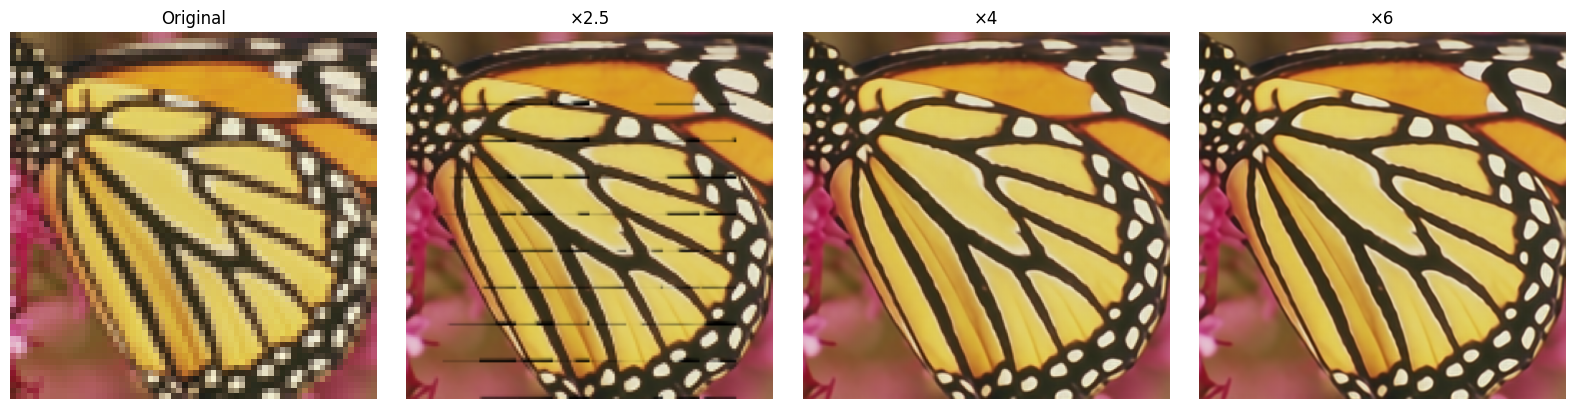

In [5]:
# Load image and model
img = transforms.ToTensor()(Image.open(args.input).convert('RGB')).cuda()
model_spec = torch.load(args.model)['model']
model = models.make(model_spec, load_sd=True).cuda()

# Prepare scales
scales = [(1, 1), (2.5, 2.5), (4, 4), (6, 6)]  # you can add more scales
titles = ["Original", "×2.5", "×4", "×6"]
results = []

# Predict and store each scale result
with torch.no_grad():
    for s in scales:
        scale_tensor = torch.tensor([[s[0], s[1]]]).float().cuda()
        pred = model(img.unsqueeze(0), scale_tensor).squeeze(0)
        pred = pred.clamp(0, 1).cpu()
        results.append(transforms.ToPILImage()(pred))

# Also include original image for comparison
original_img = transforms.ToPILImage()(img.cpu())
results[0] = original_img  # ensure original is first

# Plot all results
plt.figure(figsize=(16, 4))
for i, (title, image) in enumerate(zip(titles, results)):
    plt.subplot(1, len(scales), i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()